## 0. Introduction
<blockquote><br>
In this notebook  we will perform other analyses not carried out in the paper and we will perform the scalability analysis on the N and S parameters.
<br> <br> </blockquote>
 

Let's load the dataset:

In [1]:
from solvers.gurobi import GurobiSolver
from managers.data import Data
import pickle

if os.path.isdir("dataset") and os.path.isfile("dataset/dataset_paper_analysis"):
        infile = open("dataset/dataset_paper_analysis",'rb')
        instance_sets = pickle.load(infile)
        infile.close()
else:
    raise Exception("Cannot find dataset! You must execute the first notebook if you have no dataset folder")

And let's define the get_results function:

In [2]:
from timeit import default_timer as timer
import copy

def get_results(relative_gap,instance_sets,instance_type=None,allow_for_printer=True,log=False):
    results=dict()
    for indx, inst_group in enumerate(instance_sets):
        for instance in inst_group:
            if instance_type is None or (instance_type is not None and instance == instance_type):
                start = timer()
                new_instance=copy.deepcopy(inst_group[instance])
                if (allow_for_printer==False):
                    new_instance.force_no_printer_solutions()
                problem=GurobiSolver(new_instance,MIPGap=relative_gap,max_time=3600) 
                result=problem.solve()
                end = timer()
                result["TotalTime"]=end-start
                del result["Solution"]
                if instance not in results:
                    results[instance]=list()
                results[instance].append(result)
        if log:
            print("Solved instance group number "+str(indx)+". Relative gap: "+str(relative_gap))
    return results

## 1. Number of printable items
<hr><br>
<blockquote><br>
An analyses that haven't been evaluated by the authors of the paper is how the number of printable items with respect to the non printable ones affect the total revenue and the number of printers to bring.

<br>   </blockquote>

### 1.1 Random choice
In this subsection we will evaluate results with respect to number of printable items if the choice of which items are printable among all the possible item is taken in accord to a uniform distribution. We'll use the N100D100S20 instance set and a relative gap of 0.001. We will choice a subset of items as printable one, with the cardinality of this subset being the [10,20,30,40,50,60,70,80,90,100] % of the total number of item.

#### Solve each instance and store results in csv:

In [3]:
from pathlib import Path
import random
from utils.utils import from_dict_to_csv

card_N_p = [10,20,30,40,50,60,70,80,90,100]    

if os.path.isdir("results/new_analysis/N_p"):
    card_N_p=[]

Path("results").mkdir(parents=True, exist_ok=True)
Path("results/new_analysis").mkdir(parents=True, exist_ok=True)
Path("results/new_analysis/N_p").mkdir(parents=True, exist_ok=True)


for el in card_N_p:
    instance_sets_N_p=copy.deepcopy(instance_sets)
    for instance in instance_sets_N_p:
        instance["instance_N100D100S50"].N_p=sorted(random.sample(list(range(instance["instance_N100D100S50"].N)),min(instance["instance_N100D100S50"].N,el))) 

    results_printers= get_results(0.001,instance_sets_N_p,instance_type="instance_N100D100S50",allow_for_printer=True,log=False)
    results_no_printers= get_results(0.001,instance_sets_N_p,instance_type="instance_N100D100S50",allow_for_printer=False,log=False)
    for result in results_printers:
        from_dict_to_csv(results_printers[result],"results/new_analysis/N_p/"+result+"_printers_N_p_"+str(el))
    for result in results_no_printers:
        from_dict_to_csv(results_no_printers[result],"results/new_analysis/N_p/"+result+"_no_printers_N_p_"+str(el))

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-22


#### Table 9 - An overview of the median, minimum, maximum and average number of both the packed 3D-printers, and the percentage increase in reward, for varying values of N_p cardinality.

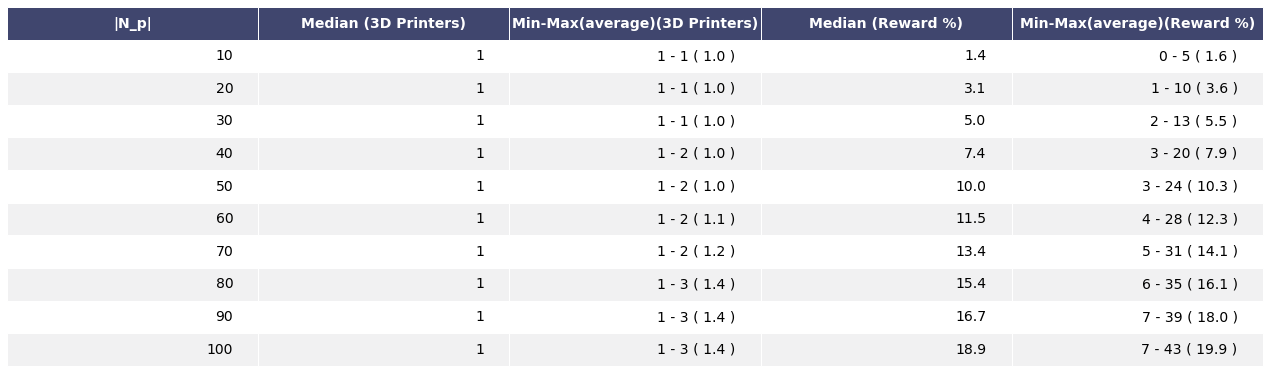

In [4]:
import pandas as pd
from utils.utils import from_dataframe_to_table

table_list=list()

card_N_p = [10,20,30,40,50,60,70,80,90,100]    

for el in card_N_p:
    df = pd.read_csv(r"results/new_analysis/N_p/instance_N100D100S50_printers_N_p_"+str(el)+".csv")
    df_noprinters=pd.read_csv(r"results/new_analysis/N_p/instance_N100D100S50_no_printers_N_p_"+str(el)+".csv")
    rev= (((df["ObjValue"]-df_noprinters["ObjValue"])/df_noprinters["ObjValue"])*100)

    dic_for_table={
        "|N_p| %": el,
        "Median (3D Printers)": int(df["Printers"].median()),
        "Min-Max(average)(3D Printers)":str(round(df["Printers"].min()))+" - "+str(round(df["Printers"].max()))+" ( "+str(round(df["Printers"].mean(),1)) +" )",
        "Median (Reward %)": round(rev.median(),1),
        "Min-Max(average)(Reward %)": str(round(rev.min()))+" - "+str(round(rev.max()))+" ( "+str(round(rev.mean(),1)) +" )",
    }
    table_list.append(dic_for_table)

from_dataframe_to_table(pd.DataFrame(table_list),col_width=4.5,row_height=0.6);

### 1.2 Weights choice with uncorrelated weights and revenues
In this subsection we will evaluate results with respect to number of printable items if the choice of which items are printable among all the possible item is taken in accord to the distribution of weights: each item as a probability of becaming a "printable item" that is proportional to the reciprocal of its weight (ie lightweight item are more likely to be printable). We'll use the N100D100S50 instance set and a relative gap of 0.001.

#### Solve each instance and store results in csv:

In [5]:
from pathlib import Path
import random
import numpy as np
from utils.utils import from_dict_to_csv

card_N_p = [10,20,30,40,50,60,70,80,90,100]    

if os.path.isdir("results/new_analysis/N_p_weighted"):
    card_N_p=[]

Path("results").mkdir(parents=True, exist_ok=True)
Path("results/new_analysis").mkdir(parents=True, exist_ok=True)
Path("results/new_analysis/N_p_weighted").mkdir(parents=True, exist_ok=True)

for el in card_N_p:
    instance_sets_N_p=copy.deepcopy(instance_sets)
    for instance in instance_sets_N_p:
        d=instance["instance_N100D100S50"]
        d.N_p=sorted(np.random.choice(a=list(range(d.N)), p=(1/d.w)/sum(1/d.w), size=el,replace=False))
    results_printers= get_results(0.001,instance_sets_N_p,instance_type="instance_N100D100S50",allow_for_printer=True,log=False)
    results_no_printers= get_results(0.001,instance_sets_N_p,instance_type="instance_N100D100S50",allow_for_printer=False,log=False)
    for result in results_printers:
        from_dict_to_csv(results_printers[result],"results/new_analysis/N_p_weighted/"+result+"_printers_N_p_"+str(el))
    for result in results_no_printers:
        from_dict_to_csv(results_no_printers[result],"results/new_analysis/N_p_weighted/"+result+"_no_printers_N_p_"+str(el))

#### Table 10 - An overview of the median, minimum, maximum and average number of both the packed 3D-printers, and the percentage increase in reward, for varying values of N_p cardinality where printable items are sampled in accord to weight distribution.

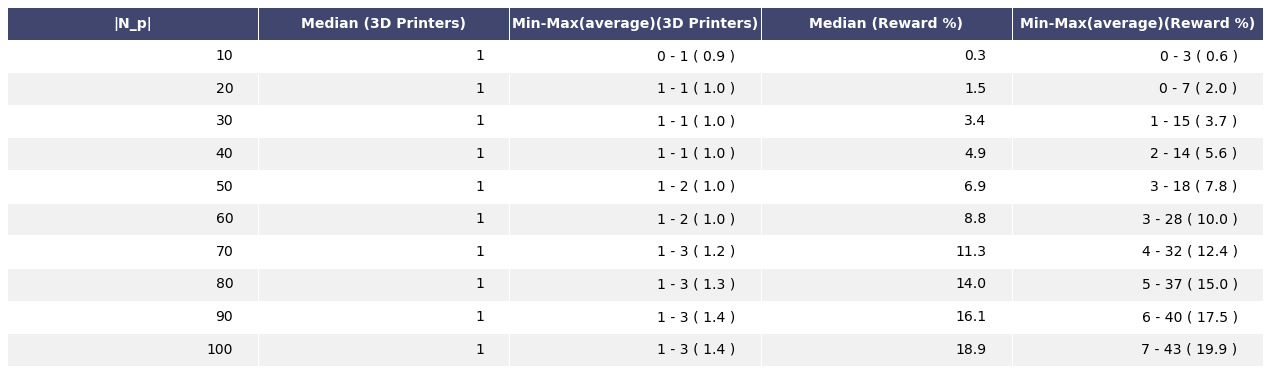

In [6]:
import pandas as pd
from utils.utils import from_dataframe_to_table
table_list=list()

card_N_p = [10,20,30,40,50,60,70,80,90,100]    

for el in card_N_p:
    df = pd.read_csv(r"results/new_analysis/N_p_weighted/instance_N100D100S50_printers_N_p_"+str(el)+".csv")
    df_noprinters=pd.read_csv(r"results/new_analysis/N_p_weighted/instance_N100D100S50_no_printers_N_p_"+str(el)+".csv")
    rev= (((df["ObjValue"]-df_noprinters["ObjValue"])/df_noprinters["ObjValue"])*100)

    dic_for_table={
        "|N_p| %": el,
        "Median (3D Printers)": int(df["Printers"].median()),
        "Min-Max(average)(3D Printers)":str(round(df["Printers"].min()))+" - "+str(round(df["Printers"].max()))+" ( "+str(round(df["Printers"].mean(),1)) +" )",
        "Median (Reward %)": round(rev.median(),1),
        "Min-Max(average)(Reward %)": str(round(rev.min()))+" - "+str(round(rev.max()))+" ( "+str(round(rev.mean(),1)) +" )",
    }
    table_list.append(dic_for_table)

from_dataframe_to_table(pd.DataFrame(table_list),col_width=4.5,row_height=0.6);

### 1.3 Weights choice with uncorrelated weights and revenues
In this subsection we will evaluate results with respect to number of printable items if the choice of which items are printable among all the possible item is taken in accord to the distribution of weights: each item as a probability of becaming a "printable item" that is proportional to its weight (ie heavyweight item are more likely to be printable). We'll use the N100D100S50 instance set and a relative gap of 0.001.

##### Solve each instance and store results in csv:

In [7]:
from pathlib import Path
import random
import numpy as np
from utils.utils import from_dict_to_csv

card_N_p = [10,20,30,40,50,60,70,80,90,100]    

if os.path.isdir("results/new_analysis/N_p_weighted_inv"):
    card_N_p=[]

Path("results").mkdir(parents=True, exist_ok=True)
Path("results/new_analysis").mkdir(parents=True, exist_ok=True)
Path("results/new_analysis/N_p_weighted_inv").mkdir(parents=True, exist_ok=True)


for el in card_N_p:
    instance_sets_N_p=copy.deepcopy(instance_sets)
    for instance in instance_sets_N_p:
        d=instance["instance_N100D100S50"]
        d.N_p=sorted(np.random.choice(a=list(range(d.N)), p=(d.w)/sum(d.w), size=el,replace=False))
    results_printers= get_results(0.001,instance_sets_N_p,instance_type="instance_N100D100S50",allow_for_printer=True,log=False)
    results_no_printers= get_results(0.001,instance_sets_N_p,instance_type="instance_N100D100S50",allow_for_printer=False,log=False)
    for result in results_printers:
        from_dict_to_csv(results_printers[result],"results/new_analysis/N_p_weighted_inv/"+result+"_printers_N_p_"+str(el))
    for result in results_no_printers:
        from_dict_to_csv(results_no_printers[result],"results/new_analysis/N_p_weighted_inv/"+result+"_no_printers_N_p_"+str(el))

#### Table 11 - An overview of the median, minimum, maximum and average number of both the packed 3D-printers, and the percentage increase in reward, for varying values of N_p cardinality where printable items are sampled in accord to weight distribution.

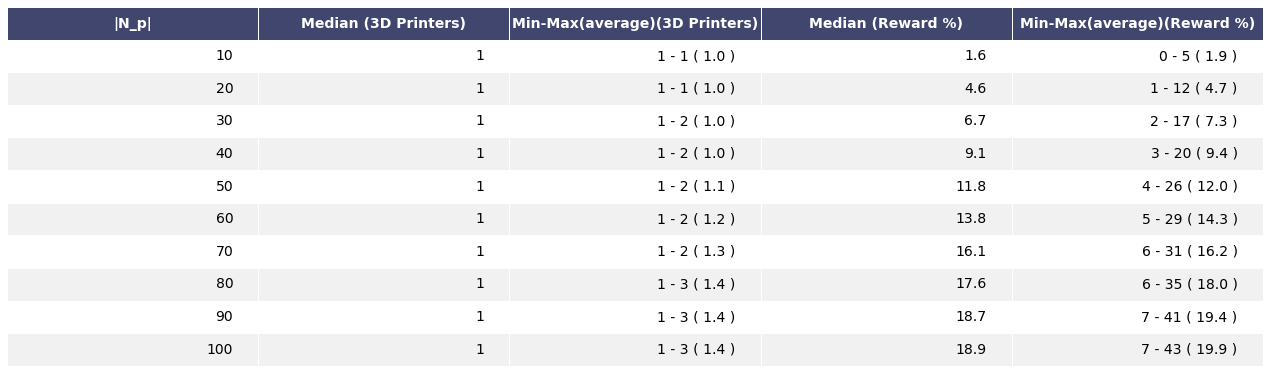

In [8]:
import pandas as pd
from utils.utils import from_dataframe_to_table
table_list=list()

card_N_p = [10,20,30,40,50,60,70,80,90,100]    

for el in card_N_p:
    df = pd.read_csv(r"results/new_analysis/N_p_weighted_inv/instance_N100D100S50_printers_N_p_"+str(el)+".csv")
    df_noprinters=pd.read_csv(r"results/new_analysis/N_p_weighted_inv/instance_N100D100S50_no_printers_N_p_"+str(el)+".csv")
    rev= (((df["ObjValue"]-df_noprinters["ObjValue"])/df_noprinters["ObjValue"])*100)

    dic_for_table={
        "|N_p| %": el,
        "Median (3D Printers)": int(df["Printers"].median()),
        "Min-Max(average)(3D Printers)":str(round(df["Printers"].min()))+" - "+str(round(df["Printers"].max()))+" ( "+str(round(df["Printers"].mean(),1)) +" )",
        "Median (Reward %)": round(rev.median(),1),
        "Min-Max(average)(Reward %)": str(round(rev.min()))+" - "+str(round(rev.max()))+" ( "+str(round(rev.mean(),1)) +" )",
    }
    table_list.append(dic_for_table)

from_dataframe_to_table(pd.DataFrame(table_list),col_width=4.5,row_height=0.6);

# 3. Scalability analyses

 
<hr><br>
<blockquote><br>
Here we will try to understand how the model behave in terms of computation time when we vary the number of items N and the number of scenarios S. 

<br>   </blockquote>


##### First of all let's generate all the instances that we will use (or load them if already present):

In [11]:
from managers.data import Data
from pathlib import Path
import os
import pickle

Path("dataset").mkdir(parents=True, exist_ok=True)
instance_types= {"instance_N100D100S50","instance_N200D100S50","instance_N100D200S50","instance_N100D100S100","instance_N200D200S100" }
instance_sets=dict()

trial=20

N=[100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500]

instance_sets["NXD100S50"]=list()
for i in N:
    instances=list()
    for e in range(trial):
        instances.append(Data(i,100,50))
    instance_sets["NXD100S50"].append(instances)

S=[50,100,150,200,250,300,350,400,450,500]

instance_sets["N100D100SX"]=list()
for i in S:
    instances=list()
    for e in range(trial):
        instances.append(Data(100,100,i))
    instance_sets["N100D100SX"].append(instances)
 
instance_sets["N200D100SX"]=list()
for i in S:
    instances=list()
    for e in range(trial):
        instances.append(Data(200,100,i))
    instance_sets["N200D100SX"].append(instances)

if os.path.isdir("dataset"):
    if os.path.isfile("dataset/dataset_scalability_analysis"):
        infile = open("dataset/dataset_scalability_analysis",'rb')
        instance_sets = pickle.load(infile)
        infile.close()
        
outfile = open("dataset/dataset_scalability_analysis",'wb')
pickle.dump(instance_sets,outfile)
outfile.close()

## 3.1 Number of item N
In this section we analyze the N100D100S50 type instances, trying to understand the variations in computation times when N increase. In the first analysis we will vary N in [100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500] and we will look for the maximum, minimum and average computation on 20 instances for each N. We will also have the average number of cuts and nodes of the branch & cut algorithm.

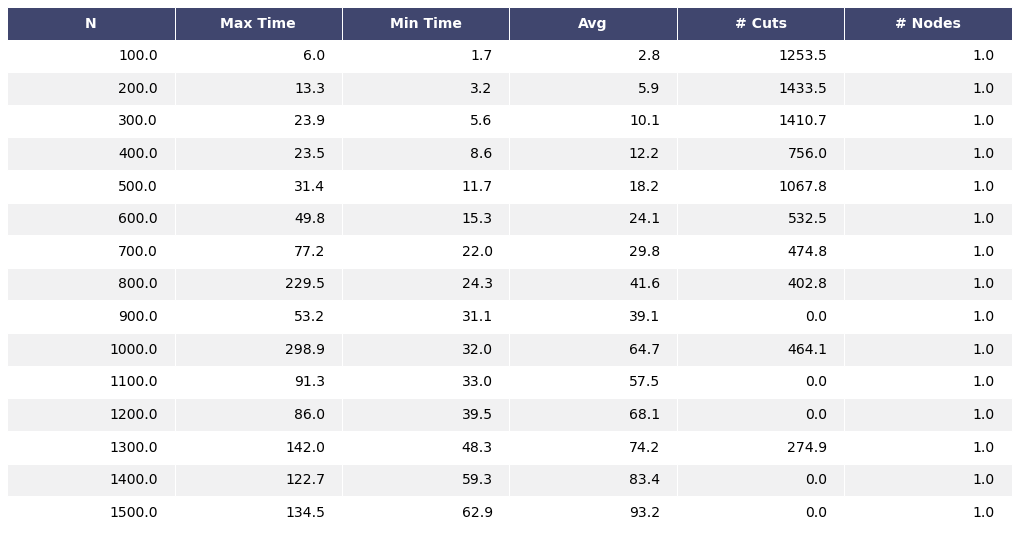

In [12]:
from timeit import default_timer as timer
from statistics import mean
from solvers.gurobi import GurobiSolver
from utils.utils import from_dataframe_to_table
import pandas as pd
import ast
import copy
from pathlib import Path
from utils.utils import from_csv_to_list
from utils.utils import from_list_to_csv

results=list()

if os.path.isfile("results/scalability/time_N_1000.csv"):
    results=[ast.literal_eval(e) for e in from_csv_to_list("results/scalability/time_N_1000.csv")]


Path("results").mkdir(parents=True, exist_ok=True)
Path("results/scalability").mkdir(parents=True, exist_ok=True)
if not(os.path.isfile("results/scalability/time_N_1000.csv")):
    for n in range(len(instance_sets["NXD100S50"])):
        trials=list()
        for i in range(len(instance_sets["NXD100S50"][n])):
            d=instance_sets["NXD100S50"][n][i]
            start=timer() 
            res=GurobiSolver(d,MIPGap=0.001).solve()
            end=timer()
            trials.append([end-start,res["Cuts"],res["Nodes"]])
        #max,min,mean,cuts,nodes
        results.append([round(max([e[0] for e in trials]),1),round(min([e[0] for e in trials]),1),round(mean([e[0] for e in trials]),1),round(mean([e[1] for e in trials]),1),round(mean([e[2] for e in trials]),1)])

from_list_to_csv("results/scalability/time_N_1000.csv",results)

from_dataframe_to_table(pd.DataFrame([[int((r+1)*100)]+results[r] for r in range(len(results))], index=None, columns=["N","Max Time (s)","Min Time (s)", "Avg (s)","# Cuts","# Nodes"], dtype=None, copy=None),row_height=0.6);

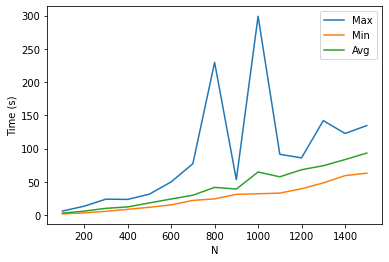

In [13]:
import matplotlib.pyplot as plt


plt.xlabel('N')
plt.ylabel("Time (s)")
x=[(r+1)*100 for r in range(len(results))]
y=list(map(list, zip(*results)))
plt.plot(x,y[0], label = "Max"), plt.plot(x,y[1], label = "Min"), plt.plot(x,y[2], label = "Avg")
plt.legend()

Path("figures").mkdir(parents=True, exist_ok=True)
plt.savefig('figures/time_N.png')
plt.show()


## 3.2 Number of Scenarios S (with N=100)
In this section we analyze the N100D100S50 type instances, trying to understand the variations in computation times when S increase. In the first analysis we will vary S in [50,100,150,200,250,300,350,400,450,500] and we will look for the maximum, minimum and average computation on 20 instances for each N. We will also have the average number of cuts and nodes of the branch & cut algorithm.

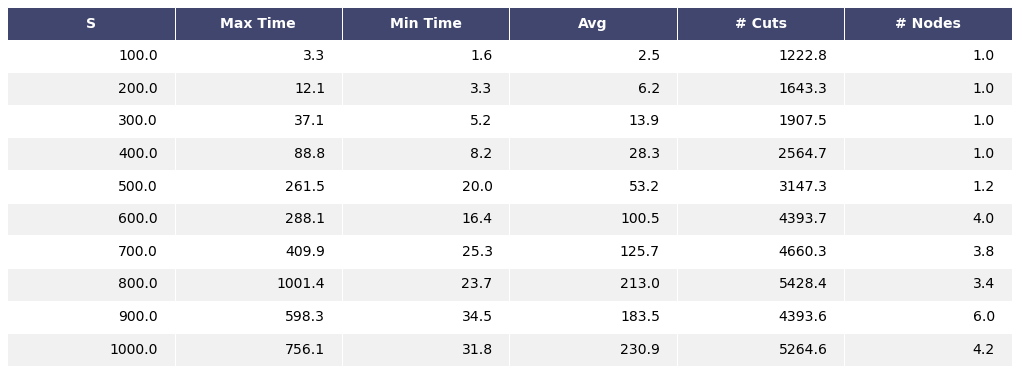

In [14]:
results=list()

if os.path.isfile("results/scalability/time_S_500.csv"):
    results=[ast.literal_eval(e) for e in from_csv_to_list("results/scalability/time_S_500.csv")]


Path("results").mkdir(parents=True, exist_ok=True)
Path("results/scalability").mkdir(parents=True, exist_ok=True)
if not(os.path.isfile("results/scalability/time_S_500.csv")):
    for n in range(len(instance_sets["N100D100SX"])):
        trials=list()
        for i in range(len(instance_sets["N100D100SX"][n])):
            d=instance_sets["N100D100SX"][n][i]
            start=timer() 
            res=GurobiSolver(d,MIPGap=0.001).solve()
            end=timer()
            trials.append([end-start,res["Cuts"],res["Nodes"]])
        #max,min,mean,cuts,nodes
        results.append([round(max([e[0] for e in trials]),1),round(min([e[0] for e in trials]),1),round(mean([e[0] for e in trials]),1),round(mean([e[1] for e in trials]),1),round(mean([e[2] for e in trials]),1)])

from_list_to_csv("results/scalability/time_S_500.csv",results)

from_dataframe_to_table(pd.DataFrame([[int((r+1)*100)]+results[r] for r in range(len(results))], index=None, columns=["S","Max Time (s)","Min Time (s)", "Avg (s)","# Cuts","# Nodes"], dtype=None, copy=None),row_height=0.6);

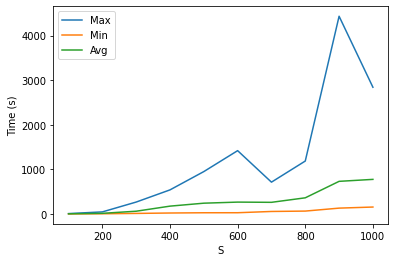

In [18]:
plt.xlabel('S')
plt.ylabel("Time (s)")
x=[(r+1)*100 for r in range(len(results))]
y=list(map(list, zip(*results)))
plt.plot(x,y[0], label = "Max"), plt.plot(x,y[1], label = "Min"), plt.plot(x,y[2], label = "Avg")
plt.legend()

Path("figures").mkdir(parents=True, exist_ok=True)
plt.savefig('figures/time_S_N100.png')
plt.show()


## 3.3 Number of Scenarios S (with N=200)
In this section we analyze the N200D100S50 type instances, trying to understand the variations in computation times when S increase. In the first analysis we will vary S in [50,100,150,200,250,300,350,400,450,500] and we will look for the maximum, minimum and average computation on 20 instances for each N. We will also have the average number of cuts and nodes of the branch & cut algorithm.

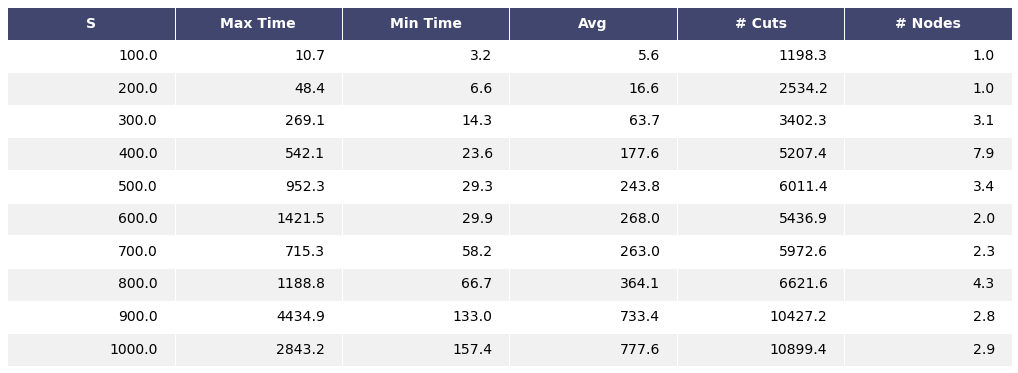

In [16]:
results=list()

if os.path.isfile("results/scalability/time_S_500_N_200.csv"):
    results=[ast.literal_eval(e) for e in from_csv_to_list("results/scalability/time_S_500_N_200.csv")]


Path("results").mkdir(parents=True, exist_ok=True)
Path("results/scalability").mkdir(parents=True, exist_ok=True)
if not(os.path.isfile("results/scalability/time_S_500_N_200.csv")):
    for n in range(len(instance_sets["N200D100SX"])):
        trials=list()
        for i in range(len(instance_sets["N200D100SX"][n])):
            d=instance_sets["N200D100SX"][n][i]
            start=timer() 
            res=GurobiSolver(d,MIPGap=0.001).solve()
            end=timer()
            trials.append([end-start,res["Cuts"],res["Nodes"]])
        #max,min,mean,cuts,nodes
        results.append([round(max([e[0] for e in trials]),1),round(min([e[0] for e in trials]),1),round(mean([e[0] for e in trials]),1),round(mean([e[1] for e in trials]),1),round(mean([e[2] for e in trials]),1)])

from_list_to_csv("results/scalability/time_S_500_N_200.csv",results)

from_dataframe_to_table(pd.DataFrame([[int((r+1)*100)]+results[r] for r in range(len(results))], index=None, columns=["S","Max Time (s)","Min Time (s)", "Avg (s)","# Cuts","# Nodes"], dtype=None, copy=None),row_height=0.6);

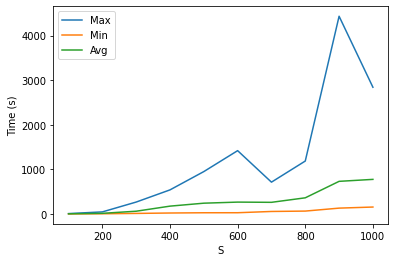

In [19]:
plt.xlabel('S')
plt.ylabel("Time (s)")
x=[(r+1)*100 for r in range(len(results))]
y=list(map(list, zip(*results)))
plt.plot(x,y[0], label = "Max"), plt.plot(x,y[1], label = "Min"), plt.plot(x,y[2], label = "Avg")
plt.legend()

Path("figures").mkdir(parents=True, exist_ok=True)
plt.savefig('figures/time_S_N200.png')
plt.show()
